<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/05_LDA_TopicModels_GENSIM_Coherence_Analisis_DATOS_SAMPLEADOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [2]:
%%capture
!pip install pyLDAvis==2.1.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# Data

In [ ]:
Tipo_Datos = "sampleados"  ##### ELIJA: "totales" O "sampleados".

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos == "sampleados":
  data = data_Sampleada
elif Tipo_Datos == "totales":
  data = data_Total
data



,text
0,used think output translation machine would st...
1,program determination divided routines analysi...
2,statistical study made extent russian nouns en...
3,paper concerned use electrical networks automa...
4,les recherches depuis quelques en vue de la tr...
...,...
18663,patronizing condescending language pcl large h...
18664,language models plms shown great potentials na...
18665,named entity recognition ner aims borrow entit...
18666,product listing ads plas primary online advert...


In [ ]:
if Tipo_Datos == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()
dataset[0]

'used think output translation machine would stylistically inelegant would tolerable message got across find getting message across accurately difficult may able stylistic elegance output since much style reflects depth phenomena thus systematic example order clauses many twoclause sentences reversed without change meaning normally true sentences two clauses meaning usually changes clause order changed equivalently appear severe restrictions clause order given meaning restrictions appear follow depth considerations idea investigated normal clause order deviations order must signalled special syntactic semantic devices nature devices explored translating sentences may trouble due fact clause types two languages exactly parallel therefore list allowed preferred clause orders two languages equivalent special syntactic semantic devices available signal deviations normal order different thus one would predict sentences language often split two sentences translated language time sentences la

In [ ]:
type(dataset)


list

# Preproc

## Limpieza

In [ ]:
STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

In [ ]:
print(texts[100])

['nan']


## Ajustes para LDA

In [ ]:
### dictionary:
dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
print(len(dictionary))

dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.
print(len(dictionary))

#Documentacion de filter_extremes: https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html

37082
7917


In [ ]:
### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario
len(corpus) 

18668

In [ ]:
#### SETEO DE SEMILLA:
semilla = 420
# before training/inference:
np.random.seed(semilla)

In [ ]:
### TF-IDF:
from gensim import corpora, models

#tfidf = models.TfidfModel(bow_corpus)
tfidf = models.TfidfModel(corpus)

#corpus_tfidf = tfidf[bow_corpus]
corpus_tfidf = tfidf[corpus]

#from pprint import pprint
#for text in corpus_tfidf:
 #   pprint(text)
  #  break
len(corpus_tfidf)

18668

## LDA con BOW, LDA con TF-IDF y LSI (diag. matrices).

In [ ]:
#### PRUEBA INICIAL CON 10 TOPICOS (MAS ADELANTE BUSCAREMOS CANT. OPTIMA DE TOPICOS):
n_topics = 10

In [ ]:
### LSI: trabaja diagonalizando matrices y disminuyendo dimensionalidad, similar a un ACP:
np.random.seed(semilla)
lsamodel = LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [ ]:
lsamodel.print_topics(n_topics,8)


[(0,
  '-0.679*"de" + -0.280*"la" + -0.277*"des" + -0.233*"les" + -0.211*"et" + -0.174*"le" + -0.174*"un" + -0.165*"une"'),
 (1,
  '0.298*"language" + 0.263*"model" + 0.227*"data" + 0.220*"models" + 0.173*"paper" + 0.168*"translation" + 0.165*"task" + 0.138*"results"'),
 (2,
  '-0.544*"translation" + 0.398*"model" + 0.301*"models" + -0.236*"system" + -0.200*"machine" + -0.186*"corpus" + -0.165*"language" + -0.131*"mt"'),
 (3,
  '-0.561*"translation" + 0.363*"corpus" + -0.323*"model" + 0.250*"language" + -0.206*"machine" + 0.185*"annotation" + 0.156*"data" + -0.137*"models"'),
 (4,
  '-0.772*"language" + -0.251*"models" + 0.189*"corpus" + 0.167*"system" + -0.149*"languages" + 0.144*"task" + 0.130*"information" + 0.118*"paper"'),
 (5,
  '0.796*"data" + -0.315*"word" + 0.210*"training" + -0.159*"words" + -0.155*"language" + -0.146*"information" + -0.132*"semantic" + 0.107*"models"'),
 (6,
  '-0.542*"word" + 0.386*"system" + 0.332*"task" + -0.244*"data" + -0.205*"words" + -0.165*"embedding

In [ ]:
# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)


In [ ]:
ldamodel.print_topics(10, 8)

[(0,
  '0.129*"et" + 0.089*"augmentation" + 0.045*"al" + 0.035*"extractive" + 0.022*"gradient" + 0.021*"st" + 0.019*"patients" + 0.017*"perturbations"'),
 (1,
  '0.019*"language" + 0.011*"data" + 0.011*"research" + 0.010*"annotation" + 0.009*"paper" + 0.009*"nlp" + 0.008*"information" + 0.007*"text"'),
 (2,
  '0.023*"semantic" + 0.014*"neural" + 0.013*"parsing" + 0.011*"structure" + 0.011*"syntactic" + 0.010*"dependency" + 0.009*"graph" + 0.008*"discourse"'),
 (3,
  '0.037*"model" + 0.029*"models" + 0.016*"task" + 0.016*"tasks" + 0.016*"learning" + 0.014*"performance" + 0.012*"propose" + 0.011*"datasets"'),
 (4,
  '0.074*"de" + 0.031*"des" + 0.030*"la" + 0.027*"les" + 0.022*"et" + 0.019*"le" + 0.018*"un" + 0.018*"une"'),
 (5,
  '0.022*"text" + 0.016*"social" + 0.014*"evaluation" + 0.014*"human" + 0.013*"news" + 0.013*"generation" + 0.012*"dataset" + 0.012*"summarization"'),
 (6,
  '0.032*"languages" + 0.019*"word" + 0.017*"language" + 0.013*"words" + 0.012*"english" + 0.012*"corpus" + 

In [ ]:
#### LDA MODEL USANDO TF-IDF COMO INPUT (EN VEZ DE UNA BOLSA DE PALABRAS bow2word):

# Running LDA using TF-IDF (from Susan Li: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24):

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topics, id2word=dictionary, passes=10, workers=4, random_state=semilla)


## NOTA: USE EL LdaMulticore DE SUSAN LI, PORQUE NO FUNCIONA DE CON EL LdaModel DE LOS PROFES, DA UNA COHERENCIA NEGATIVA!!!!
#ESTE ERA EL DE LOS PROFES:
#lda_model_tfidf = LdaModel(corpus=corpus_tfidf, num_topics=10, id2word=dictionary, iterations = 200, passes=10
                    # , random_seed = semilla
#                    )



In [ ]:
#### PRUEBA DE COMO CLASIFICARIA UN NUEVO TEXTO, USANDO EL MODELO LDA BOW ENTRENADO:
#LOS RESULTADOS: PARA ESE NUEVO TEXTO: PROBABILIDAD DE CADA TOPICO Y TOP WORDS DEL TOPICO MAS PROBABLE.
new_text = dataset[0]

# transform held_out_text into the bag-of-words space
bow_vector = dictionary.doc2bow(tokenize(new_text.lower()))
lda_vector = ldamodel[bow_vector]
print(lda_vector)
# print the document's single most prominent LDA topic
print(ldamodel.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

[(2, 0.4099776), (3, 0.097811714), (6, 0.23451647), (7, 0.11616038), (8, 0.13759571)]
0.023*"semantic" + 0.014*"neural" + 0.013*"parsing" + 0.011*"structure" + 0.011*"syntactic" + 0.010*"dependency" + 0.009*"graph" + 0.008*"discourse" + 0.008*"linguistic" + 0.008*"representation"


In [ ]:
#### COMPARACION DE TOPICOS ENCONTRADOS EN CADA MODELO:

### Comparacion de Topicos encontrados en cada Modelo (LDA Sklern, LDA BOW, LDA IF-IDF y LSI):

#### Topicos hallados con LDA de Sklearn (ver otra notebook):


1 embedings
6 sequence 
2 sequence
3 herramientas - implementacion
7 palabras en otro idioma? articulos? parte de nombres?
9 emotions analysis (hater etc)
5 computation and social sceince,


In [ ]:
lsatopics  = [[word for word, prob in topic] for topicid, topic in lsamodel.show_topics(n_topics,formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(n_topics,formatted=False)]

In [ ]:
ldatopics[0]

['et',
 'augmentation',
 'al',
 'extractive',
 'gradient',
 'st',
 'patients',
 'perturbations',
 'perturbation',
 'substitution']

In [ ]:
lda_tf_idf_topics = [[word for word, prob in topic] for topicid, topic in lda_model_tfidf.show_topics(n_topics,formatted=False)]

In [ ]:
lda_tf_idf_topics[0]

['disentanglement',
 'ape',
 'forgetting',
 'indic',
 'formality',
 'catastrophic',
 'cca',
 'triage',
 'replay',
 'universality']

### **Comparación de los resultados de cada Modelo, según la coherencia media de los tópicos hallados:**




In [ ]:
#window_size=30,coherence='c_npmi',topn=5 #ORIGINAL PROFES
#AJUSTE LA WINDOW Y EL TOP WORDS DE ACUERDO A DOCUMENTACION HALLADA Y AL CASO DE ESTUDIO:
lsa_coherence = CoherenceModel(topics=lsatopics, texts=texts, dictionary=dictionary, window_size=10,coherence='c_npmi',topn=20).get_coherence_per_topic()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10,coherence='c_npmi',topn=20).get_coherence_per_topic()

In [ ]:
lda_tf_idf_coherence = CoherenceModel(topics=lda_tf_idf_topics, texts=texts, dictionary=dictionary, window_size=10,coherence='c_npmi',topn=20).get_coherence_per_topic()

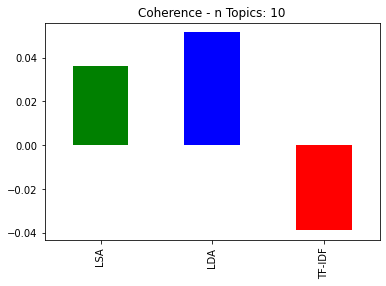

In [ ]:
#### COMPARACION DE LAS COHERENCIAS MEDIAS HALLADAS EN LOS DISTINTOS MODELOS:
df_lda = pd.DataFrame([range(10),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
df_lsa = pd.DataFrame([range(10),lsa_coherence,lsatopics],index=['topic_id','coherence','topic']).transpose()
df_tf_idf = pd.DataFrame([range(10),lda_tf_idf_coherence,lda_tf_idf_topics],index=['topic_id','coherence','topic']).transpose()

pd.Series({'LSA':np.mean(lsa_coherence),'LDA':np.mean(lda_coherence),'TF-IDF':np.mean(lda_tf_idf_coherence)}).plot.bar(title="Coherence - n Topics: 10", color=["green","blue","red"]);

### **Visualización de los (10) Tópicos hallados en cada Modelo:**

In [ ]:
### LDA TOPICS:
# GRAFICO LDA doc2bow:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.136941  0.020439       1        1  17.013075
3     -0.136669 -0.000507       2        1  15.887410
1     -0.085439 -0.012185       3        1  14.738202
6     -0.104678 -0.003785       4        1  13.590373
8     -0.081522 -0.008903       5        1  10.074372
4      0.399610 -0.287564       6        1   9.374416
2     -0.086884  0.016079       7        1   7.830049
5     -0.086676 -0.007628       8        1   5.620368
9     -0.059154 -0.019983       9        1   5.252229
0      0.378355  0.304036      10        1   0.619506, topic_info=           Term          Freq         Total Category  logprob  loglift
280          de   9696.000000   9696.000000  Default  30.0000  30.0000
287          et   4044.000000   4044.000000  Default  29.0000  29.0000
32    languages   6467.000000   6467.000000  Default  28.0000  28.0000
355       model  11235.000000  11235.000000  Default  27.0000  27.0000
1297     models  10904.000000  10904.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
5058     traits     79.195913    107.643318  Topic10  -4.6957   4.7771
3463         si    103.137554    214.670445  Topic10  -4.4315   4.3510
4774   sessions     61.512412     85.603967  Topic10  -4.9484   4.7535
1478  cognitive     78.878495    327.041908  Topic10  -4.6997   3.6618
4181         ne     57.380594    393.447592  Topic10  -5.0179   3.1588

[637 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6434      5  0.994763     ablation
7648      8  0.995597  abstractive
7513      5  0.996448      abusive
5119      3  0.993986     academic
2327      5  0.995540     acoustic
...     ...       ...          ...
549       9  0.054073         work
3009      3  0.993975     workflow
1424      5  0.997770     workshop
3949      4  0.995071          wsd
3854      4  0.994912         zero

[1328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 2, 7, 9, 5, 3, 6, 10, 1])

In [ ]:
### LDA TF-IDF TOPICS:
# GRAFICO LA doc2bow:
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.147823 -0.046847       1        1  48.429297
7      0.123141 -0.049999       2        1  19.421314
8      0.128438 -0.050946       3        1  12.288910
4     -0.358903 -0.126252       4        1   9.259374
1      0.111768 -0.055717       5        1   5.539492
6      0.083955 -0.015750       6        1   3.700816
2      0.010822  0.113714       7        1   0.785013
9     -0.085919  0.129150       8        1   0.250192
5     -0.081350  0.052545       9        1   0.166764
0     -0.079775  0.050101      10        1   0.158827, topic_info=             Term         Freq        Total Category  logprob  loglift
280            de  5518.000000  5518.000000  Default  30.0000  30.0000
282           des  2446.000000  2446.000000  Default  29.0000  29.0000
291            la  2394.000000  2394.000000  Default  28.0000  28.0000
294           les  2100.000000  2100.000000  Default  27.0000  27.0000
72    translation  3709.000000  3709.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
608        unless     0.445632    24.095647  Topic10  -8.5147   2.4548
3222     facility     0.786940    48.273984  Topic10  -7.9461   2.3286
5152    inductive     1.137357    76.958172  Topic10  -7.5778   2.2306
7353   retraining     1.056335    82.631263  Topic10  -7.6517   2.0855
7223        trust     0.505829    96.321521  Topic10  -8.3880   1.1959

[627 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
7604      1  0.024491  absa
7604      2  0.024491  absa
7604      3  0.024491  absa
7604      4  0.048983  absa
7604      5  0.024491  absa
...     ...       ...   ...
7607      3  0.160997  yelp
7607      4  0.107331  yelp
7607      5  0.053666  yelp
7607      6  0.053666  yelp
7607      8  0.482990  yelp

[3717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 9, 5, 2, 7, 3, 10, 6, 1])

## **Análisis de cantidad óptima de Topics, por métrica de Coherencia interna total y promedio:**

### ***Pruebas manuales:***

LSA Mean Coherence: 0.08 LSA
LDA Mean Coherence: 0.09 LDA
LDA Mean Coherence: 0.07 TF-IF


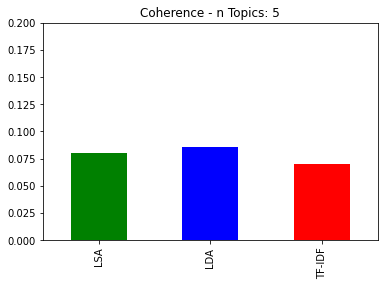

In [ ]:
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIA TOTAL Y PROMEDIO:
nro_topics = 5 # INGRESE MANUALMENTE NRO DE TOPICOS 
window_size_=10  # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=20  # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

semilla = 420
np.random.seed(semilla)

### LSI NO USA SEMILLA, PORQUE NO ES UN MODELO ESTOCASTICO/ESTADISTICO!, ES UN CALCULO MATRICIAL!
lsamodel = LsiModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary)

ldamodel = LdaModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=nro_topics, id2word=dictionary, passes=10, workers=4, random_state=semilla)

lsatopics  = [[word for word, prob in topic] for topicid, topic in lsamodel.show_topics(nro_topics,formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(nro_topics,formatted=False)]
lda_tf_idf_topics = [[word for word, prob in topic] for topicid, topic in lda_model_tfidf.show_topics(nro_topics,formatted=False)]

lsa_coherence = CoherenceModel(topics=lsatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_tf_idf_coherence = CoherenceModel(topics=lda_tf_idf_topics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()

df_lda = pd.DataFrame([range(5),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
df_lsa = pd.DataFrame([range(5),lsa_coherence,lsatopics],index=['topic_id','coherence','topic']).transpose()
df_tf_idf = pd.DataFrame([range(5),lda_tf_idf_coherence,lda_tf_idf_topics],index=['topic_id','coherence','topic']).transpose()

title = "Coherence - n Topics: " + str(nro_topics)
pd.Series({'LSA':np.mean(lsa_coherence),'LDA':np.mean(lda_coherence),'TF-IDF':np.mean(lda_tf_idf_coherence)}).plot.bar(title=title, ylim=(0,0.20), color=["green","blue","red"]);
print('LSA Mean Coherence: %.2f LSA' % (np.mean(lsa_coherence)))
print('LDA Mean Coherence: %.2f LDA' % (np.mean(lda_coherence)))
print('LDA Mean Coherence: %.2f TF-IF' % (np.mean(lda_tf_idf_coherence)))

LSA Mean Coherence: 0.04 LSA
LDA Mean Coherence: 0.05 LDA
LDA Mean Coherence: -0.04 TF-IF


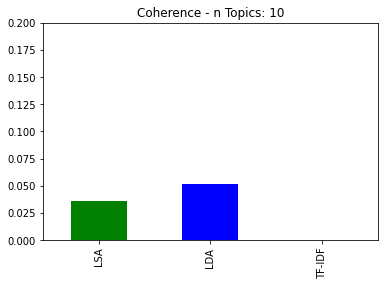

In [ ]:
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIAS PROMEDIO:
nro_topics = 10 # INGRESE MANUALMENTE NRO DE TOPICOS 
window_size_=10  # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=20  # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

semilla = 420
np.random.seed(semilla)

### LSI NO USA SEMILLA, PORQUE NO ES UN MODELO ESTOCASTICO/ESTADISTICO!, ES UN CALCULO MATRICIAL!
lsamodel = LsiModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary)

ldamodel = LdaModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=nro_topics, id2word=dictionary, passes=10, workers=4, random_state=semilla)

lsatopics  = [[word for word, prob in topic] for topicid, topic in lsamodel.show_topics(nro_topics,formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(nro_topics,formatted=False)]
lda_tf_idf_topics = [[word for word, prob in topic] for topicid, topic in lda_model_tfidf.show_topics(nro_topics,formatted=False)]

lsa_coherence = CoherenceModel(topics=lsatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_tf_idf_coherence = CoherenceModel(topics=lda_tf_idf_topics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()

df_lda = pd.DataFrame([range(10),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
df_lsa = pd.DataFrame([range(10),lsa_coherence,lsatopics],index=['topic_id','coherence','topic']).transpose()
df_tf_idf = pd.DataFrame([range(10),lda_tf_idf_coherence,lda_tf_idf_topics],index=['topic_id','coherence','topic']).transpose()

title = "Coherence - n Topics: " + str(nro_topics)
pd.Series({'LSA':np.mean(lsa_coherence),'LDA':np.mean(lda_coherence),'TF-IDF':np.mean(lda_tf_idf_coherence)}).plot.bar(title=title, ylim=(0,0.20), color=["green","blue","red"]);
print('LSA Mean Coherence: %.2f LSA' % (np.mean(lsa_coherence)))
print('LDA Mean Coherence: %.2f LDA' % (np.mean(lda_coherence)))
print('LDA Mean Coherence: %.2f TF-IF' % (np.mean(lda_tf_idf_coherence)))

LSA Mean Coherence: -0.01 LSA
LDA Mean Coherence: -0.05 LDA
LDA Mean Coherence: -0.21 TF-IF


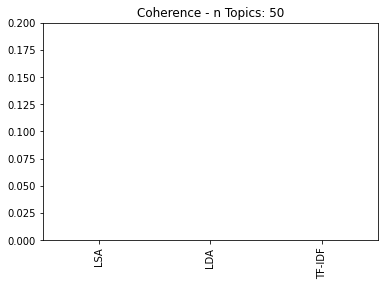

In [ ]:
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIAS PROMEDIO:
nro_topics = 50 # INGRESE MANUALMENTE NRO DE TOPICOS 
window_size_=10  # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=20  # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 

semilla = 420
np.random.seed(semilla)

lsamodel = LsiModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary)

ldamodel = LdaModel(corpus=corpus, num_topics=nro_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=nro_topics, id2word=dictionary, passes=10, workers=4, random_state=semilla)

lsatopics  = [[word for word, prob in topic] for topicid, topic in lsamodel.show_topics(nro_topics,formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(nro_topics,formatted=False)]
lda_tf_idf_topics = [[word for word, prob in topic] for topicid, topic in lda_model_tfidf.show_topics(nro_topics,formatted=False)]

lsa_coherence = CoherenceModel(topics=lsatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
lda_tf_idf_coherence = CoherenceModel(topics=lda_tf_idf_topics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()

df_lda = pd.DataFrame([range(50),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
df_lsa = pd.DataFrame([range(50),lsa_coherence,lsatopics],index=['topic_id','coherence','topic']).transpose()
df_tf_idf = pd.DataFrame([range(50),lda_tf_idf_coherence,lda_tf_idf_topics],index=['topic_id','coherence','topic']).transpose()

title = "Coherence - n Topics: " + str(nro_topics)
pd.Series({'LSA':np.mean(lsa_coherence),'LDA':np.mean(lda_coherence),'TF-IDF':np.mean(lda_tf_idf_coherence)}).plot.bar(title=title, ylim=(0,0.20), color=["green","blue","red"]);
print('LSA Mean Coherence: %.2f LSA' % (np.mean(lsa_coherence)))
print('LDA Mean Coherence: %.2f LDA' % (np.mean(lda_coherence)))
print('LDA Mean Coherence: %.2f TF-IF' % (np.mean(lda_tf_idf_coherence)))

## **Analisis Automático (Grid Search) de cantidad óptima de Topics:**
###Considerandos:
- Utilizaremos solo el Modelo LDA bow, por demostrar ser superior en todos los escenarios ensayados al LSA y al LDA TF-IDF.
- Agregaremos al análisis la medición de la Coherencia Total (sumatoria total de las coherencias de todos los topicos), por considerar que la Coherencia Media podría ser insuficiente.

In [ ]:
##** Analisis Automático (Grid Search) de cantidad óptima de Topics** 

In [ ]:
##### CON MEDIA NO ES COMPARABLE: 
### ****HACER SUMATORIA TOTAL COHERENCIA!!!! PARA COMPARAR NUMERO DE TOPICS!!!!****

In [ ]:
type(lda_coherence)

list

## **Grid Search Automático:**
#### ***Setee parámetros de búsqueda:***
#### - *Cantidad mínima de Topics a evaluar  (=5).*
#### - *Cantidad máxima de Topics a evaluar  (=60).*
#### - *Step (=5).*

##### ***Setee parámetros de evaluación:***
##### - *Windows size  (=10).*
##### - *Tipo de métrica de Coherencia  (='c_npmi').*
##### - *Top Words/Topic to evaluate (=30).*


In [ ]:
################# GRID SEARCH ###############################
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIAS TOTALES Y PROMEDIO:
#### SOLO LO HAREMOS CON EL MODELO LDA CON BOW VECTOR, DADO QUE RESULTO MEJOR Q EL LSI Y EL TD-IDF:
Cant_Topics_Min = 5   # INGRESE CANTIDAD MINIMA DE TOPICOS A EVALUAR.
Cant_Topics_Max = 60  # INGRESE CANTIDAD MAXIMA DE TOPICOS A EVALUAR.
Step = 5              # INGRESE STEP.

window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
Grid_Search = range(Cant_Topics_Min, Cant_Topics_Max + Step, Step)  

Max_Coherence_Total = 0
Max_Topic_Total = 0
Max_Coherence_Media = 0
Max_Topic_Media = 0
Coherence_Total_array = []
Coherence_Media_array = []
N_Topics_array = []
Models_array = []
Topics_Models_array = []

for n_topics in Grid_Search:
  semilla = 420
  np.random.seed(semilla)

  ldamodel = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)
  
  ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(n_topics,formatted=False)]
  
  lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
  
  df_lda = pd.DataFrame([range(n_topics),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
  
  Coherence_Total_array.append(sum(lda_coherence))
  Coherence_Media_array.append(np.mean(lda_coherence))
  N_Topics_array.append(n_topics)
  Models_array.append(ldamodel)
  Topics_Models_array.append(ldatopics)

  if sum(lda_coherence) > Max_Coherence_Total:
    Max_Coherence_Total = sum(lda_coherence)
    Max_Topic_Total = n_topics

  if np.mean(lda_coherence) > Max_Coherence_Media:
    Max_Coherence_Media = np.mean(lda_coherence)
    Max_Topic_Media = n_topics 
    
  print(" ")
  print('n Topics: %.2f ' % (n_topics))
  print('LDA Mean Coherence: %.2f ' % (round(np.mean(lda_coherence),2)))
  print('LDA Total Coherence: %.2f ' % (round(sum(lda_coherence),2)))


print("--------------------------------------------------------------- ")
print(" ")
print("Final Results:")
print(" ")
print('Max Coherence Total: %.2f ' % (Max_Coherence_Total))
print('N Topics Total Optimo: %.2f ' % (Max_Topic_Total))
print(" ")
print('Max Coherence Media: %.2f ' % (Max_Coherence_Media))
print('N Topics Media Optimo: %.2f ' % (Max_Topic_Media))
print("--------------------------------------------------------------- ")


"""##### RESULTADOS CON DATOS TOTALES (NO SAMPLEADOS):

n Topics: 5.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.48 
 
n Topics: 10.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.88 
 
n Topics: 15.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 1.23 
 
n Topics: 20.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 1.87 
 
n Topics: 25.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.60 
 
n Topics: 30.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.84 
 
n Topics: 35.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 2.34 
 
n Topics: 40.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.37 
 
n Topics: 45.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.68 
 
n Topics: 50.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 1.95 
 
n Topics: 55.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 1.47 
 
n Topics: 60.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.87 
--------------------------------------------------------------- 
 
Final Results:
 
Max Coherence Total: 2.68 
N Topics Total Optimo: 45.00 
 
Max Coherence Media: 0.10 
N Topics Media Optimo: 5.00 
--------------------------------------------------------------- """

#####################################################
"""RESULTADOS CON DATOS SAMPLEADOS:
n Topics: 5.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.43 
 
n Topics: 10.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.51 
 
n Topics: 15.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 0.57 
 
n Topics: 20.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 0.63 
 
n Topics: 25.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.13 
 
n Topics: 30.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.25 
 
n Topics: 35.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.32 
 
n Topics: 40.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.54 
 
n Topics: 45.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.27 
 
n Topics: 50.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.45 
 
n Topics: 55.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.78 
 
n Topics: 60.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -2.58 
--------------------------------------------------------------- 
 
Final Results:
 
Max Coherence Total: 0.63 
N Topics Total Optimo: 20.00 
 
Max Coherence Media: 0.09 
N Topics Media Optimo: 5.00 
---------------------------------------------------------------""" 





 
n Topics: 5.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.43 
 
n Topics: 10.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.51 
 
n Topics: 15.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 0.57 
 
n Topics: 20.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 0.63 
 
n Topics: 25.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.13 
 
n Topics: 30.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.25 
 
n Topics: 35.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.32 
 
n Topics: 40.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.54 
 
n Topics: 45.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.27 
 
n Topics: 50.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.45 
 
n Topics: 55.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.78 
 
n Topics: 60.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -2.58 
--------------------------------------------------------------- 
 
Final Results:
 
Max Coherence Total: 0.63 
N Topics Tot

'##### RESULTADOS CON DATOS TOTALES:\n\nn Topics: 5.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 0.48 \n \nn Topics: 10.00 \nLDA Mean Coherence: 0.09 \nLDA Total Coherence: 0.88 \n \nn Topics: 15.00 \nLDA Mean Coherence: 0.08 \nLDA Total Coherence: 1.23 \n \nn Topics: 20.00 \nLDA Mean Coherence: 0.09 \nLDA Total Coherence: 1.87 \n \nn Topics: 25.00 \nLDA Mean Coherence: 0.06 \nLDA Total Coherence: 1.60 \n \nn Topics: 30.00 \nLDA Mean Coherence: 0.06 \nLDA Total Coherence: 1.84 \n \nn Topics: 35.00 \nLDA Mean Coherence: 0.07 \nLDA Total Coherence: 2.34 \n \nn Topics: 40.00 \nLDA Mean Coherence: 0.06 \nLDA Total Coherence: 2.37 \n \nn Topics: 45.00 \nLDA Mean Coherence: 0.06 \nLDA Total Coherence: 2.68 \n \nn Topics: 50.00 \nLDA Mean Coherence: 0.04 \nLDA Total Coherence: 1.95 \n \nn Topics: 55.00 \nLDA Mean Coherence: 0.03 \nLDA Total Coherence: 1.47 \n \nn Topics: 60.00 \nLDA Mean Coherence: 0.01 \nLDA Total Coherence: 0.87 \n----------------------------------------------------

## **Gráficos de evolución de la Coherencia Media y Total en función de la cant. de Topics:**
#### ***Setee parámetros visualización:***
#### - *Tipo de gráfico: "barras" ó "lineas".*

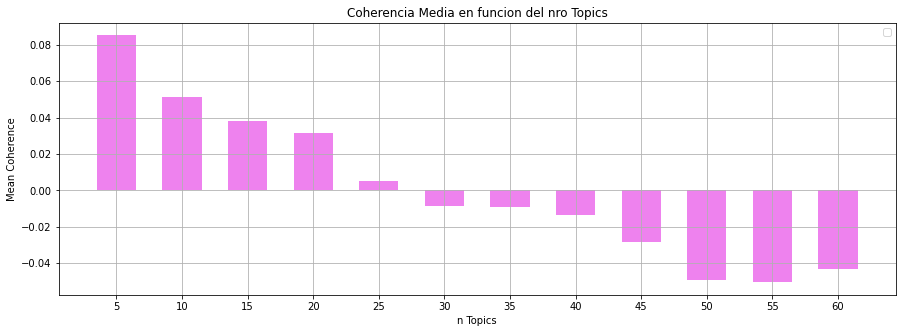

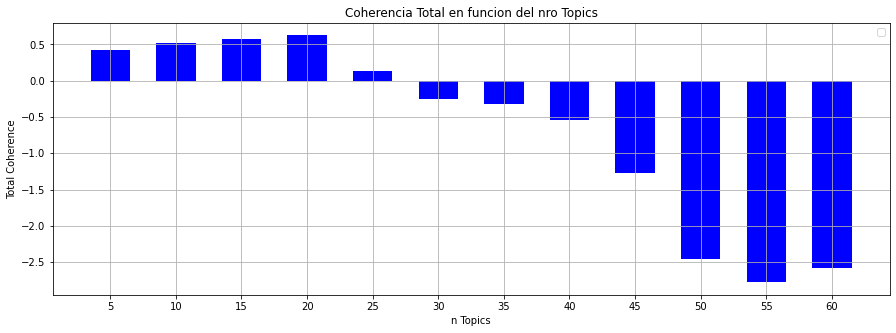

In [ ]:
Tipo_Grafico = "barras"  ###INGRESE TIPO DE GRAFICO: "barras" o "lineas"


for i in range(0,2):
  plt.figure(figsize=[15,5])
  x=N_Topics_array
  if i == 1:
    y=Coherence_Total_array
    title_="Coherencia Total en funcion del nro Topics"
    lable_y="Total Coherence"
    color_="b"
  elif i == 0:
    y=Coherence_Media_array
    title_="Coherencia Media en funcion del nro Topics"
    lable_y="Mean Coherence"
    color_="violet"

  values = N_Topics_array 

  if Tipo_Grafico == "barras":
    plt.bar(x,y, color=color_, width=3)
  elif Tipo_Grafico == "lineas": 
    plt.plot(x,y, color=color_, linewidth=3, marker="o")

  plt.title(title_)
  plt.xlabel("n Topics")
  plt.ylabel(lable_y)
  plt.legend()
  plt.xticks(x,values)
  plt.grid()
  plt.show()
  print(" ")


## ***Análisis fino de la cant. óptima de Topics:***

## **Grid Search Automático:**
#### ***Setee parámetros de búsqueda:***
#### - *Cantidad mínima de Topics a evaluar  (=2).*
#### - *Cantidad máxima de Topics a evaluar  (=60).*
#### - ***Step (=1).***

##### *Setee parámetros de evaluación:*
##### - *Windows size  (=10).*
##### - *Tipo de métrica de Coherencia  (='c_npmi').*
##### - *Top Words/Topic to evaluate (=30).*

In [ ]:
################# GRID SEARCH ###############################
#### ANALIZADOR DE CANTIDAD OPTIMA DE TOPICOS, POR COMPARACION DE COHERENCIAS TOTALES Y PROMEDIO:
#### SOLO LO HAREMOS CON EL MODELO LDA CON BOW VECTOR, DADO QUE RESULTO MEJOR Q EL LSI Y EL TD-IDF:
Cant_Topics_Min = 2   # INGRESE CANTIDAD MINIMA DE TOPICOS
Cant_Topics_Max = 60  # INGRESE CANTIDAD MAXIMA DE TOPICOS
Step = 1              # INGRESE STEP

window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
Grid_Search = range(Cant_Topics_Min, Cant_Topics_Max + Step, Step)  


Max_Coherence_Total = 0
Max_Topic_Total = 0
Max_Coherence_Media = 0
Max_Topic_Media = 0
Coherence_Total_array = []
Coherence_Media_array = []
N_Topics_array = []
Models_array = []
Topics_Models_array = []

for n_topics in Grid_Search:
  semilla = 420
  np.random.seed(semilla)

  ldamodel = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)
  
  ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(n_topics,formatted=False)]
  
  lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
  
  df_lda = pd.DataFrame([range(n_topics),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
  
  Coherence_Total_array.append(sum(lda_coherence))
  Coherence_Media_array.append(np.mean(lda_coherence))
  N_Topics_array.append(n_topics)
  Models_array.append(ldamodel)
  Topics_Models_array.append(ldatopics)

  if sum(lda_coherence) > Max_Coherence_Total:
    Max_Coherence_Total = sum(lda_coherence)
    Max_Topic_Total = n_topics

  if np.mean(lda_coherence) > Max_Coherence_Media:
    Max_Coherence_Media = np.mean(lda_coherence)
    Max_Topic_Media = n_topics 
    
  print(" ")
  print('n Topics: %.2f ' % (n_topics))
  print('LDA Mean Coherence: %.2f ' % (round(np.mean(lda_coherence),2)))
  print('LDA Total Coherence: %.2f ' % (round(sum(lda_coherence),2)))

print("--------------------------------------------------------------- ")
print(" ")
print("Final Results:")
print(" ")
print('Max Coherence Total: %.2f ' % (Max_Coherence_Total))
print('N Topics Total Optimo: %.2f ' % (Max_Topic_Total))
print(" ")
print('Max Coherence Media: %.2f ' % (Max_Coherence_Media))
print('N Topics Media Optimo: %.2f ' % (Max_Topic_Media))
print("--------------------------------------------------------------- ")


#########################################################
"""RESULTADOS CON *DATOS TOTALES* (NO SAMPLEADOS):
n Topics: 5.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.52 
 
n Topics: 6.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.57 
 
n Topics: 7.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.72 
 
n Topics: 8.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.78 
 
n Topics: 9.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.84 
 
n Topics: 10.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.93 
 
n Topics: 11.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 0.89 
 
n Topics: 12.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 1.11 
 
n Topics: 13.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 1.26 
 
n Topics: 14.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.77 
 
n Topics: 15.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 1.26 
 
n Topics: 16.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 1.33 
 
n Topics: 17.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 1.55 
 
n Topics: 18.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 1.68 
 
n Topics: 19.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 1.87 
 
n Topics: 20.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 1.32 
 
n Topics: 21.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.18 
 
n Topics: 22.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 1.79 
 
n Topics: 23.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 1.04 
 
n Topics: 24.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 1.65 
 
n Topics: 25.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 2.15 
 
n Topics: 26.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 2.38 
 
n Topics: 27.00 
LDA Mean Coherence: 0.08 
LDA Total Coherence: 2.05 
 
n Topics: 28.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.54 
 
n Topics: 29.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.85 
 
n Topics: 30.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.77 
 
n Topics: 31.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 2.14 
 
n Topics: 32.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 2.33 
 
n Topics: 33.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 1.84 
 
n Topics: 34.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 1.58 
 
n Topics: 35.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 0.94 
 
n Topics: 36.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.05 
 
n Topics: 37.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.38 
 
n Topics: 38.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 1.69 
 
n Topics: 39.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 1.76 
 
n Topics: 40.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 1.58 
 
n Topics: 41.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 2.08 
 
n Topics: 42.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.53 
 
n Topics: 43.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 2.23 
 
n Topics: 44.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.61 
 
n Topics: 45.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 1.40 
 
n Topics: 46.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 1.98 
 
n Topics: 47.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 2.59 
 
n Topics: 48.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 2.13 
 
n Topics: 49.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 1.73 
 
n Topics: 50.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 1.48 
 
n Topics: 51.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 2.52 
 
n Topics: 52.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 1.64 
 
n Topics: 53.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 2.04 

(*SE INTERRUMPIO EL PROCESO EN LA ITERACION DE N TOPICS: 53*)
"""

###############################################
"""RESULTADOS CON *DATOS SAMPLEADOS*:
n Topics: 2.00 
LDA Mean Coherence: 0.19 
LDA Total Coherence: 0.37 
 
n Topics: 3.00 
LDA Mean Coherence: 0.13 
LDA Total Coherence: 0.39 
 
n Topics: 4.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.41 
 
n Topics: 5.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.43 
 
n Topics: 6.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.33 
 
n Topics: 7.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 0.44 
 
n Topics: 8.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.43 
 
n Topics: 9.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.45 
 
n Topics: 10.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.51 
 
n Topics: 11.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.53 
 
n Topics: 12.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 0.80 
 
n Topics: 13.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 0.72 
 
n Topics: 14.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.23 
 
n Topics: 15.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 0.57 
 
n Topics: 16.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.36 
 
n Topics: 17.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.24 
 
n Topics: 18.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.24 
 
n Topics: 19.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.47 
 
n Topics: 20.00 
LDA Mean Coherence: 0.03 
LDA Total Coherence: 0.63 
 
n Topics: 21.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.33 
 
n Topics: 22.00 
LDA Mean Coherence: -0.00 
LDA Total Coherence: -0.07 
 
n Topics: 23.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.49 
 
n Topics: 24.00 
LDA Mean Coherence: -0.00 
LDA Total Coherence: -0.09 
 
n Topics: 25.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.13 
 
n Topics: 26.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.24 
 
n Topics: 27.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.39 
 
n Topics: 28.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.16 
 
n Topics: 29.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.20 
 
n Topics: 30.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.25 
 
n Topics: 31.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.17 
 
n Topics: 32.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.42 
 
n Topics: 33.00 
LDA Mean Coherence: -0.00 
LDA Total Coherence: -0.05 
 
n Topics: 34.00 
LDA Mean Coherence: 0.01 
LDA Total Coherence: 0.18 
 
n Topics: 35.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.32 
 
n Topics: 36.00 
LDA Mean Coherence: -0.02 
LDA Total Coherence: -0.68 
 
n Topics: 37.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.44 
 
n Topics: 38.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.06 
 
n Topics: 39.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -1.61 
 
n Topics: 40.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.54 
 
n Topics: 41.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -1.44 
 
n Topics: 42.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.29 
 
n Topics: 43.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -1.81 
 
n Topics: 44.00 
LDA Mean Coherence: -0.02 
LDA Total Coherence: -0.99 
 
n Topics: 45.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.27 
 
n Topics: 46.00 
LDA Mean Coherence: -0.02 
LDA Total Coherence: -0.83 
 
n Topics: 47.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.35 
 
n Topics: 48.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -1.70 
 
n Topics: 49.00 
LDA Mean Coherence: -0.03 
LDA Total Coherence: -1.67 
 
n Topics: 50.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.45 
 
n Topics: 51.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.38 
 
n Topics: 52.00 
LDA Mean Coherence: -0.01 
LDA Total Coherence: -0.49 
 
n Topics: 53.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.80 
 
n Topics: 54.00 
LDA Mean Coherence: -0.06 
LDA Total Coherence: -3.33 
 
n Topics: 55.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.78 
 
n Topics: 56.00 
LDA Mean Coherence: -0.05 
LDA Total Coherence: -2.64 
 
n Topics: 57.00 
LDA Mean Coherence: -0.06 
LDA Total Coherence: -3.25 
 
n Topics: 58.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -2.53 
 
n Topics: 59.00 
LDA Mean Coherence: -0.06 
LDA Total Coherence: -3.43 
 
n Topics: 60.00 
LDA Mean Coherence: -0.04 
LDA Total Coherence: -2.58 
--------------------------------------------------------------- 
 
Final Results:
 
Max Coherence Total: 0.80 
N Topics Total Optimo: 12.00 
 
Max Coherence Media: 0.19 
N Topics Media Optimo: 2.00 
---------------------------------------------------------------"""



 
n Topics: 2.00 
LDA Mean Coherence: 0.19 
LDA Total Coherence: 0.37 
 
n Topics: 3.00 
LDA Mean Coherence: 0.13 
LDA Total Coherence: 0.39 
 
n Topics: 4.00 
LDA Mean Coherence: 0.10 
LDA Total Coherence: 0.41 
 
n Topics: 5.00 
LDA Mean Coherence: 0.09 
LDA Total Coherence: 0.43 
 
n Topics: 6.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.33 
 
n Topics: 7.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 0.44 
 
n Topics: 8.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.43 
 
n Topics: 9.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.45 
 
n Topics: 10.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.51 
 
n Topics: 11.00 
LDA Mean Coherence: 0.05 
LDA Total Coherence: 0.53 
 
n Topics: 12.00 
LDA Mean Coherence: 0.07 
LDA Total Coherence: 0.80 
 
n Topics: 13.00 
LDA Mean Coherence: 0.06 
LDA Total Coherence: 0.72 
 
n Topics: 14.00 
LDA Mean Coherence: 0.02 
LDA Total Coherence: 0.23 
 
n Topics: 15.00 
LDA Mean Coherence: 0.04 
LDA Total Coherence: 0.57 


'RESULTADOS CON DATOS TOTALES (NO SAMPLEADOS):\nn Topics: 5.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 0.52 \n \nn Topics: 6.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 0.57 \n \nn Topics: 7.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 0.72 \n \nn Topics: 8.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 0.78 \n \nn Topics: 9.00 \nLDA Mean Coherence: 0.09 \nLDA Total Coherence: 0.84 \n \nn Topics: 10.00 \nLDA Mean Coherence: 0.09 \nLDA Total Coherence: 0.93 \n \nn Topics: 11.00 \nLDA Mean Coherence: 0.08 \nLDA Total Coherence: 0.89 \n \nn Topics: 12.00 \nLDA Mean Coherence: 0.09 \nLDA Total Coherence: 1.11 \n \nn Topics: 13.00 \nLDA Mean Coherence: 0.10 \nLDA Total Coherence: 1.26 \n \nn Topics: 14.00 \nLDA Mean Coherence: 0.05 \nLDA Total Coherence: 0.77 \n \nn Topics: 15.00 \nLDA Mean Coherence: 0.08 \nLDA Total Coherence: 1.26 \n \nn Topics: 16.00 \nLDA Mean Coherence: 0.08 \nLDA Total Coherence: 1.33 \n \nn Topics: 17.00 \nLDA Mean Coherence: 0.09 \n

In [ ]:
#### TRAIGO A MANO LOS RESULTADOS, PARA GRAFICAR, PORQUE SE CAYO EL COLAB ANTES DE TERMINAR:
"""N_Topics_array = pd.read_excel("n_Topics.xlsx")
N_Topics_array.head()
N_Topics_array = N_Topics_array["n_Topics"].tolist()

Coherence_Total_array = pd.read_excel("LDA_Total_Coherence.xlsx")
Coherence_Total_array.head()
Coherence_Total_array = Coherence_Total_array["LDA Total Coherence"].tolist()

Coherence_Media_array = pd.read_excel("LDA_Mean_Coherence.xlsx")
Coherence_Media_array.head()
Coherence_Media_array = Coherence_Media_array["LDA Mean Coherence"].tolist()

print(type(N_Topics_array))
print(len(N_Topics_array))
print(type(Coherence_Total_array))
print(len(Coherence_Total_array))
print(type(Coherence_Media_array))
print(len(Coherence_Media_array))"""

<class 'list'>
49
<class 'list'>
49
<class 'list'>
49


## **Gráficos de evolución de la Coherencia Media y Total en función de la cant. de Topics: Analisis de granularidad fina (Step=1)**
#### ***Setee parámetros visualización:***
#### - *Tipo de gráfico: "barras" ó "lineas".*

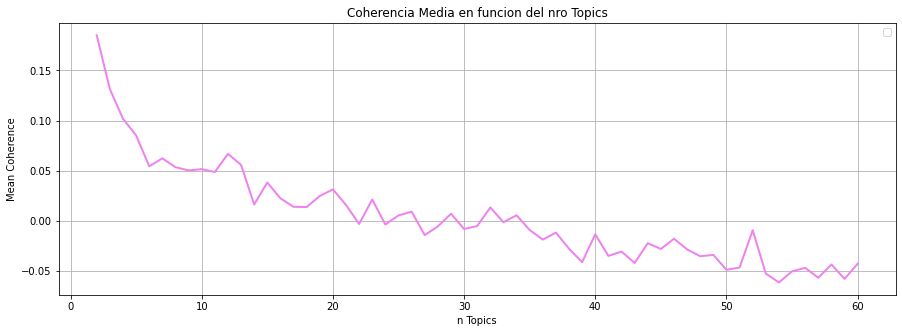

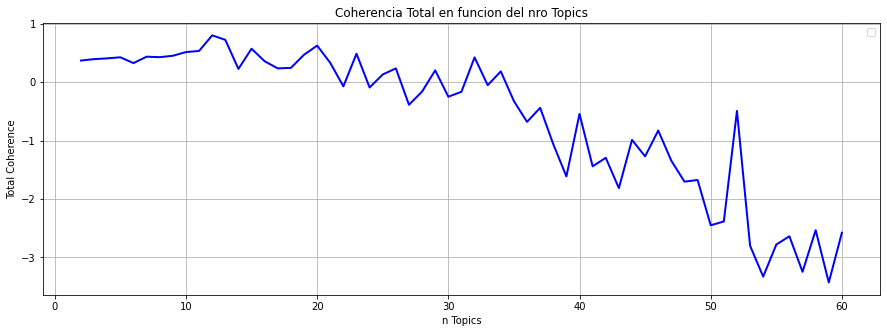

In [ ]:
Tipo_Grafico = "lineas"  ###INGRESE TIPO DE GRAFICO: "barras" o "lineas"

#fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
#plt.subplots(1, 2)

#plt.figure(figsize=[10,4])
for i in range(0,2):
  plt.figure(figsize=[15,5])
  x=N_Topics_array
  if i == 1:
    y=Coherence_Total_array
    title_="Coherencia Total en funcion del nro Topics"
    lable_y="Total Coherence"
    color_="b"
  elif i == 0:
    y=Coherence_Media_array
    title_="Coherencia Media en funcion del nro Topics"
    lable_y="Mean Coherence"
    color_="violet"

  #values = N_Topics_array 

  if Tipo_Grafico == "barras":
    plt.bar(x,y, color=color_, width=0.5)
  elif Tipo_Grafico == "lineas": 
    plt.plot(x,y, color=color_, linewidth=2)

  #plt.plot(pd.DataFrame(Coherence_Total_array, index=N_Topics_array), label='Coherence Total', color="b", linewidth=2)
  plt.title(title_)
  plt.xlabel("n Topics")
  plt.ylabel(lable_y)
  plt.legend()
  #plt.xticks(x,values)
  plt.grid()
  plt.show()
  print(" ")


###***Resultados preliminares del análisis de la cant. óptima de tópicos:***

####***A) Resultados para Datos Totales (sin samplear):***
Nótese, como tanto para la coherencia media como para la total, **se observan picos máximos en alrededor de 19 topics y en 26 topics.** En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, **podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos.**

Sin embargo, **un análisis más profundo y de carácter cualitativo será necesario** para confirmar o refutar a estas cantidades óptimas. En este sentido, **proseguiremos con los siguientes pasos:**

***1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso.***

***2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.***

***3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximos de coherencia media y total, y repetiremos pasos 1) a 3).***

####***B) Resultados para Datos Sampleados:***
Realizamos los mismos análisis anteriores, pero esta vez utilizando una base con datos sampleados, de tal forma de tomar una cantidad constante de registros por año (1812) a partir de 2016 en adelante.
Los resultados han sido bastante diferentes, **apareciendo valores negativos de coherencia** para las cantidades altas de tópicos (a partir de 22 tópicos en adelante).
Si bien estos resultados parecieran no condecir con los obtenidos previamente utilizando los datos totales (no sampleados), sí podemos observar algunas **coincidencias: vuelven a observarse picos máximos alrededor de los 20 topicos y un último pico máximo positivo en 26 tópicos**.  A su vez, **aparece un nuevo pico máximo en 12 tópicos**, que no se detectaba utilizando el total de los datos. 

Preliminarmente, **podríamos pensar que una cantidad de 19 o 20 tópicos podría llegar a ser la óptima, dado que es coincidente tanto para la totalidad de los datos como para el sampleo**. Sin embargo, **esto deberemos validarlo con un análisis cualitativo de los tópicos** y sus words más probables, como hemos ya explicado con los pasos 1) a 3).


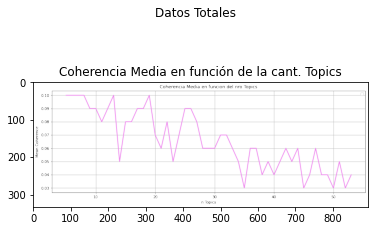

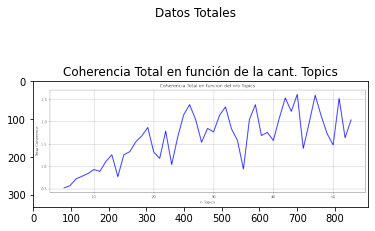

<Figure size 1080x360 with 0 Axes>

'Nótese, como tanto para la coherencia media como para la total, se observan picos máximos en alrededor de 19 topics y en 26 topics. En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos. \n   Sin embargo, un análisis más profundo y de carácter cualitativo será necesario para confirmar o refutar a estas cantidades óptimas. En este sentido, proseguiremos con los siguientes pasos: \n    1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso. \n    2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.\n    3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximo

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


imagen_1_Total = mpimg.imread("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/results/Coherencia_Media_Topics_iteracion_1_topic.png")
imgplot = plt.imshow(imagen_1_Total)
plt.suptitle("Datos Totales")
plt.title("Coherencia Media en función de la cant. Topics")
plt.show()

imagen_2_Total = mpimg.imread("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/results/Coherencia_Total_iteracion_1_topic.png")
imgplot = plt.imshow(imagen_2_Total)
plt.suptitle("Datos Totales")
plt.title("Coherencia Total en función de la cant. Topics")
plt.figure(figsize=[15,5])
plt.show()


#if Tipo_Datos == "sampleados":
 # imagen_1 = imagen_1_Sampleada
#elif Tipo_Datos == "totales":
 # imagen_1 = imagen_1_Total

"""Nótese, como tanto para la coherencia media como para la total, se observan picos máximos en alrededor de 19 topics y en 26 topics. En principio, aplicando un criterio similar al que se aplica para la métrica de Silhouette en la optimización de clusters, podríamos elegir como las cantidades de tópicos candidatas a ser las óptimas a la de 19 tópicos y a la de 26 tópicos. 
   Sin embargo, un análisis más profundo y de carácter cualitativo será necesario para confirmar o refutar a estas cantidades óptimas. En este sentido, proseguiremos con los siguientes pasos: 
    1) Analizaremos la cantidad de “tópicos basura” existentes en cada caso. 
    2) Realizaremos un análisis cualitativo (y subjetivo) del contenido semántico de las top 30 words de cada tópico contenido en dichos casos, antes de tomar una decisión.
    3) En caso de que los dos análisis anteriores resultaran negativos, volveremos a escoger una cantidad de tópicos candidata a ser óptima de entre los restantetes picos máximos de coherencia media y total, y repetiremos pasos 1) a 3).
"""






## **Creación del Modelo Óptimo (con cant. óptima de Topics), gráfico y análisis cualitativo de los Tópicos resultantes:**
### - Utilizaremos la cant. de Tópicos óptima hallada = 19 topicos.
### - Graficaremos con el pyLDAvis del gensim los Topicos hallados.
### - Analizaremos las Top Words de cada uno de los Topicos, para detectar topicos basura e identificar los buenos tópicos encontrados.

In [4]:
### LDA TOPICS:
# GRAFICO LDA doc2bow:
Tipo_Datos_ = "sampleados"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()
Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
N_Topics = Cant_Optima_Topics
print('Nro. Topics Optimo: %.2f ' % (N_Topics))
print('Coherencia Media: %.2f ' % (round(np.mean(lda_coherence),2)))
print('Coherencia Total: %.2f ' % (round(sum(lda_coherence),2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

Nro. Topics Optimo: 19.00 
Coherencia Media: 0.02 
Coherencia Total: 0.47 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.171157 -0.109960       1        1  15.873519
11    -0.267970  0.034847       2        1   9.138511
12     0.125180  0.098722       3        1   7.985896
7      0.105835  0.113848       4        1   7.718148
16     0.113500 -0.041898       5        1   7.237681
6      0.115777  0.181397       6        1   6.608403
1      0.097724  0.146683       7        1   6.073807
17     0.144426 -0.113679       8        1   5.781910
18     0.070492  0.235137       9        1   5.619661
8      0.089394  0.157270      10        1   5.337654
3      0.100029 -0.166190      11        1   5.155076
5      0.093427 -0.074068      12        1   4.396149
14     0.082812 -0.074377      13        1   3.962470
2      0.050078 -0.243214      14        1   3.152584
9      0.025535 -0.130125      15        1   2.920995
15    -0.271644 -0.066601      16        1   1.236860
4     -0.293834  0.015560      17        1   0.723954
13    -0.263125  0.047635      18        1   0.570044
0     -0.288793 -0.010990      19        1   0.506678, topic_info=               Term          Freq         Total Category  logprob  loglift
280              de   9928.000000   9928.000000  Default  30.0000  30.0000
1767         neural   4099.000000   4099.000000  Default  29.0000  29.0000
72      translation   6839.000000   6839.000000  Default  28.0000  28.0000
31         language  12961.000000  12961.000000  Default  27.0000  27.0000
993            task   8305.000000   8305.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3391         mining    125.409226    407.817994  Topic19  -4.0350   4.1058
2370  architectures     82.334286    421.968539  Topic19  -4.4558   3.6509
7867           bert     88.733632   1339.409922  Topic19  -4.3809   2.5707
7772    pretraining     64.770517    448.251984  Topic19  -4.6957   3.3505
7770     pretrained     64.502226    797.324859  Topic19  -4.6998   2.7705

[1142 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3836      8  0.992823  abilities
737       1  0.133831    ability
737       4  0.074664    ability
737       5  0.609989    ability
737       8  0.121153    ability
...     ...       ...        ...
1173      6  0.025676      world
1173      9  0.002140      world
5259      1  0.983016      worse
3949     12  0.994841        wsd
1312     16  0.977080    yielded

[2784 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 13, 8, 17, 7, 2, 18, 19, 9, 4, 6, 15, 3, 10, 16, 5, 14, 1])

### ***Topicos hallados con Datos SAMPLING:***
#### ***-Topic 1: Modelos de ML para Lenguaje y Traducción ?????***
#### ***-Topic 2: "Basura" (stop words, etc.)***
#### ***-Topic 3: Analisis semantico y sintactico del discurso ????***
#### ***-Topic 4: Investigaciones futuras y tendencias ????***
#### ***-Topic 5: Lenguaje y Emmbedings ????***
#### ***-Topic 6: Analisis del Lenguaje ???? ***
#### ***-Topic 7: Analisis de Sentimiento ok!***
#### ***-Topic 8: Sistemas Generativos de Texto/Chat-Bots ?????***
#### ***-Topic 9: Traducción automática ?***
#### ***-Topic 10: Analisis de Sentimiento ?????***
#### ***-Topic 11: Analisis Gramatical/Sintactico ????***
#### ***-Topic 12: Word Embbedings ???***
#### ***-Topic 13: Clasificacion de Textos ??***
#### ***-Topic 14: Chat-Bots ????***
#### ***-Topic 15: Scrapping ???***
#### ***-Topic 16: Redes Neuronales/parafraseo, metafora ???***
#### ***-Topic 17: Analisis multimodal o de imagenes ???***
#### ***-Topic 18: "Basura"?? o Analisis de Dialectos???***
#### ***-Topic 19: Transformers ok!?***

In [5]:
### LDA TOPICS:
# GRAFICO LDA doc2bow:
Tipo_Datos_ = "totales"  ### INGRESE DATOS A UTILIZAR: ELIJA: "totales" O "sampleados".
Cant_Optima_Topics = 19     ### INGRESE CANT. OPTIMA DE TOPICOS (En principio: 19, 20, 26, ó 12). 

from pandas.core.describe import describe_categorical_1d
data_Total = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data_Sampleada = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_clean.csv")

if Tipo_Datos_ == "sampleados":
  data = data_Sampleada
elif Tipo_Datos_ == "totales":
  data = data_Total

if Tipo_Datos_ == "sampleados":
  dataset = data.text.tolist()
elif Tipo_Datos_ == "totales":
  dataset = data.ABSTRACT
  dataset = dataset.tolist()

STOP_WORDS = stopwords.words("english")

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

if Tipo_Datos_ == "sampleados":
  texts = [word_tokenize(str(doc)) for doc in dataset]
elif Tipo_Datos_ == "totales":
  texts= [tokenize(str(doc).lower()) for doc in dataset]

dictionary = corpora.Dictionary(texts)  #crea diccionario asinandole un indice numerico a cada palabra
dictionary.filter_extremes(no_below=10, no_above=0.5)  #filtra tokens q aparencen en menos de 10 documentos y en mas de la mitad de los documentos.

### doc2bow:
corpus = [dictionary.doc2bow(text) for text in texts] #el bow cuenta cantidad de apariciones de cada palabra del diccionario

#### SETEO DE SEMILLA:
semilla = 420
np.random.seed(semilla)

# LDA realizado con el doc2bow (bolsa de palabras comun)  (NO con TF-IDF):
ldamodel_optimo = LdaModel(corpus=corpus, num_topics=Cant_Optima_Topics, id2word=dictionary, iterations = 200, passes=10, random_state=semilla)

#### COHERENCIAS TOTALES DEL MODELO:
window_size_=10     # INGRESE COHERENCIA WINDOW_SIZE 
coherence_='c_npmi' # INGRESE METRICA DE COHERENCIA 
topn_=30            # INGRESE COHERENCIA TOP WORDS TO EVALUATE. 
ldatopics_optimo = [[word for word, prob in topic] for topicid, topic in ldamodel_optimo.show_topics(Cant_Optima_Topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics_optimo, texts=texts, dictionary=dictionary, window_size=window_size_,coherence=coherence_,topn=topn_).get_coherence_per_topic()
df_lda = pd.DataFrame([range(Cant_Optima_Topics),lda_coherence,ldatopics_optimo],index=['topic_id','coherence','topic']).transpose()
Coherence_Total = (sum(lda_coherence))
Coherence_Media = (np.mean(lda_coherence))
N_Topics = Cant_Optima_Topics
print('Nro. Topics Optimo: %.2f ' % (N_Topics))
print('Coherencia Media: %.2f ' % (round(np.mean(lda_coherence),2)))
print('Coherencia Total: %.2f ' % (round(sum(lda_coherence),2)))
print(" ")

### GRAFICO DE TOPICOS DEL MODELO:
pyLDAvis.gensim.prepare(ldamodel_optimo, corpus, dictionary)

"""RESULTADOS DATOS SAMPLEADOS:
Nro. Topics Optimo: 19.00 
Coherencia Media: 0.02 
Coherencia Total: 0.47"""

"""RESULTADOS DATOS TOTALES:
Nro. Topics Optimo: 19.00 
Coherencia Media: 0.07 
Coherencia Total: 1.42"""
"""NOTESE QUE CON DATOS TOTALES LA COHERENCIA DA 3 VECES MAS ALTA"""

Nro. Topics Optimo: 19.00 
Coherencia Media: 0.07 
Coherencia Total: 1.42 
 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.180009  0.030154       1        1  13.462073
13     0.124109 -0.108522       2        1  11.480302
10     0.181562  0.152360       3        1  10.989782
8      0.091313 -0.062162       4        1   7.254461
15     0.143621  0.123657       5        1   6.373918
4      0.118338  0.080654       6        1   6.338963
1      0.142503  0.085317       7        1   5.606648
17     0.112663 -0.056089       8        1   5.400532
14    -0.317079  0.099134       9        1   5.300180
2      0.096378  0.009436      10        1   5.179580
3      0.116912  0.011727      11        1   5.167387
0      0.048990 -0.209331      12        1   4.838526
7     -0.012438 -0.092775      13        1   3.203060
16    -0.007423  0.094065      14        1   2.715511
5     -0.127281 -0.107954      15        1   2.030601
11    -0.166648 -0.305019      16        1   1.547020
6     -0.142476  0.012138      17        1   1.417428
18    -0.288356  0.109584      18        1   0.867240
12    -0.294699  0.133626      19        1   0.826789, topic_info=             Term          Freq         Total Category  logprob  loglift
4831           de  12451.000000  12451.000000  Default  30.0000  30.0000
1518  translation  12316.000000  12316.000000  Default  29.0000  29.0000
122          word   9594.000000   9594.000000  Default  28.0000  28.0000
25       language  22937.000000  22937.000000  Default  27.0000  27.0000
97          model  24071.000000  24071.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
630            et   1765.676062   5667.242569  Topic19  -2.4908   3.6292
2962       genres    249.897000    413.491608  Topic19  -4.4460   4.2918
854      examples    454.777214   1709.799185  Topic19  -3.8473   3.4711
614    robustness    183.739892    554.587180  Topic19  -4.7536   3.6907
428       samples    151.071474    709.973768  Topic19  -4.9493   3.2479

[1176 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5006      1  0.994927  abbreviations
868       3  0.993948           absa
439       4  0.994710        abusive
1622      1  0.190517         access
1622      2  0.259103         access
...     ...       ...            ...
123      17  0.000777           work
1938      4  0.996547        workers
5977     16  0.996554       workflow
4552      7  0.996293            wsd
7876      2  0.997933            xml

[2928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 14, 11, 9, 16, 5, 2, 18, 15, 3, 4, 1, 8, 17, 6, 12, 7, 19, 13])

### ***Topicos hallados con Datos TOTALES:***
#### ***-Topic 1: Modelos de ML para Lenguaje ?????***
#### ***-Topic 2: Evaluacion/Clasificacion Automatica de Textos ?????***
#### ***-Topic 3: Sistemas Generativos de Texto ????***
#### ***-Topic 4: Analisis del Lenguaje ????***
#### ***-Topic 5: Modelos ML de Analisis de Lenguaje ????***
#### ***-Topic 6: Scrapping ???? ***
#### ***-Topic 7: Word Embbedings ?***
#### ***-Topic 8: Traduccion automatica ?????***
#### ***-Topic 9: "Topico Basura": stop words, etc***
#### ***-Topic 10: Analisis Gramatical/Sintactico ?????***
#### ***-Topic 11: Clasificacion de Textos ????***
#### ***-Topic 12: Lexicons ???***
#### ***-Topic 13: Analisis de Sentimiento ok!***
#### ***-Topic 14: Chat-Bots ????***
#### ***-Topic 15: Analisis del Discurso ???***
#### ***-Topic 16: Bases de Datos/Recursos ???***
#### ***-Topic 17: Analisis multimodal o de imagenes ???***
#### ***-Topic 18: "Basura": stop words y palabras extranjeras???***
#### ***-Topic 19: "Basura"***

### ***Resultados, Conclusiones:***
###-Para una cantidad optima de 19 Topicos, ***los Datos Sampleados obtuvieron tan solo 2/19 topicos basura***; mientras ***los Datos Totales obtuvieron 3/19 topicos basura.***
###-A su vez, ***los Datos Sampleados detectaron claramente el Topico "Transformers"***; mientras ***los Datos Totales no pudieron identificarlo.***
###-Hay varios topicos identificados en ambos modelos.
###-Podriamos ***concluir que, a priori y para 19 topicos, los Datos Sampleados dan mejores resultados que usar el Total de los Datos sin sampleo.***


In [ ]:
##### ****DE ACA PARA ABAJO HAY CODIGO QUE SALIO MAL O QUE NO FUE VERIFICADO AUN**** #####

In [ ]:
###### ACA INTENTO GRAFICAR LOS TOPICS COMO HACE EL SKLEARN PERO PARA GENSIM, SIN EXITO AUN: XXXX

cant_topics = 10 #### INGRESE CANTIDAD TOPICS

import math
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = cant_topics
n_top_words = 30
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(cant_topics/5), 5, figsize=(35, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tf_vectorizer = count_vect

tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [ ]:
print('Max Coherence Total: %.2f ' % (Max_Coherence))
print('N Topics Total Optimo: %.2f ' % (Max_Topic))
print(" ")


Max Coherence Total: 2.65 
N Topics Total Optimo: 40.00 
 


In [ ]:
Max_Coherence

2.646271142888884

NameError: ignored

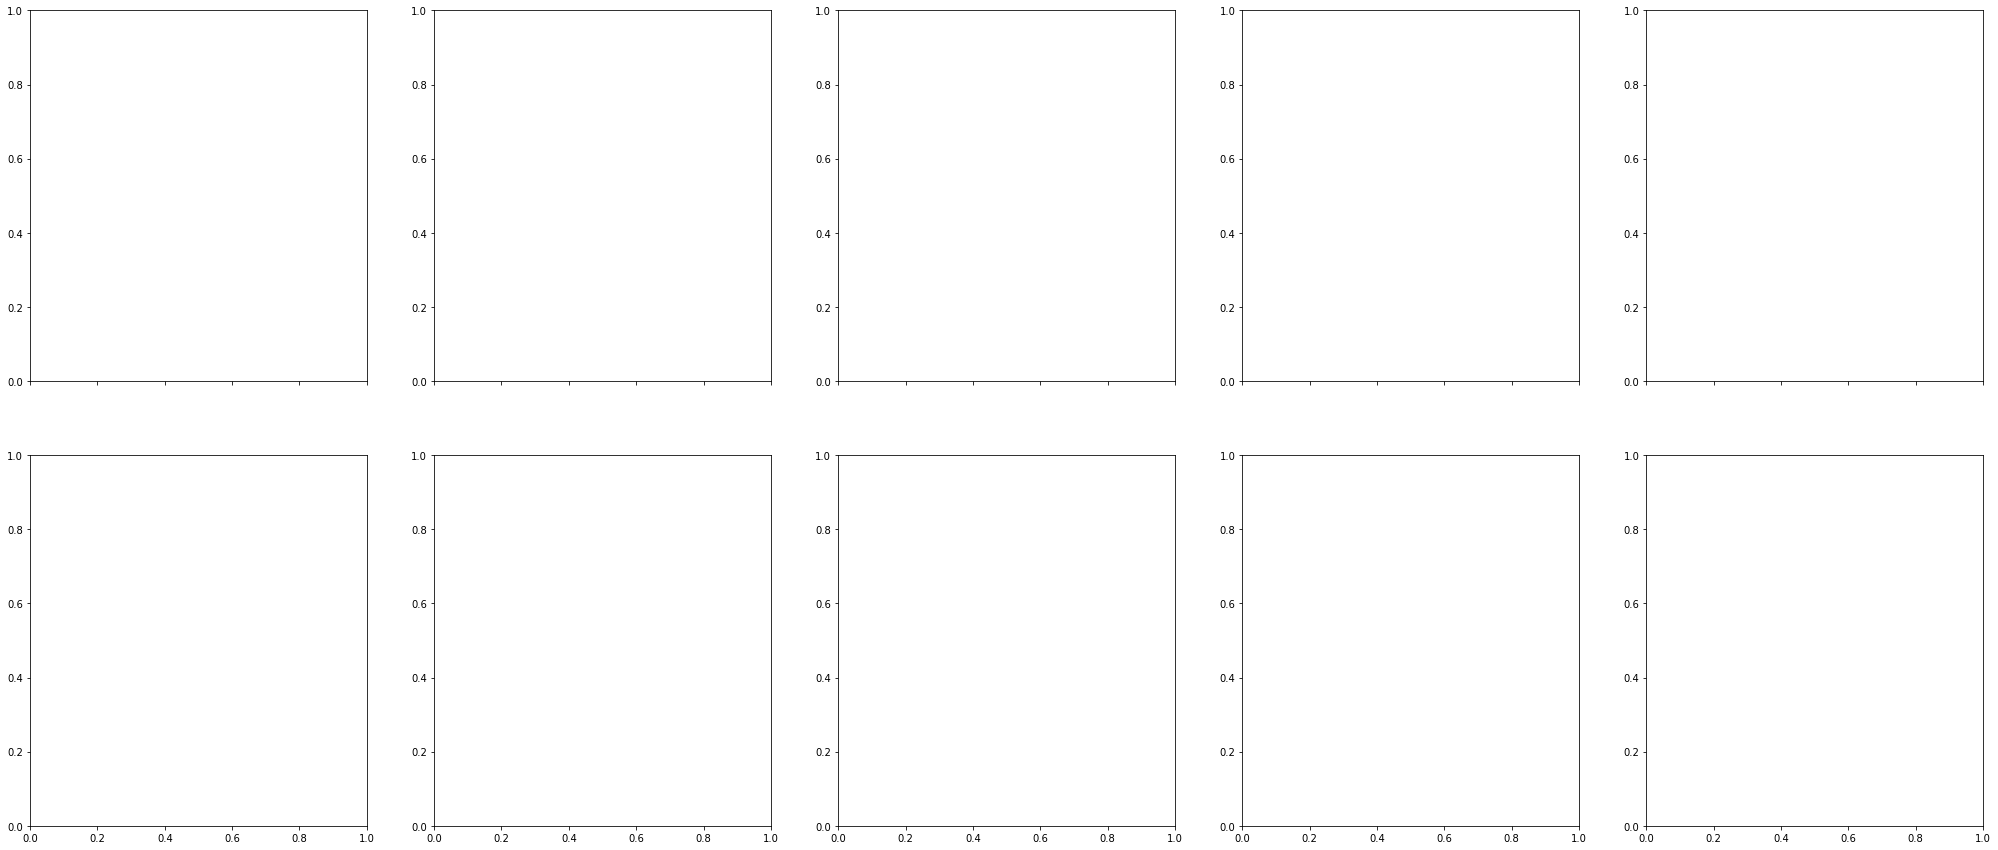

In [ ]:
n_topics = 2
title = "Coherence - n Topics: " + str(n_topics)
  #fig, ax = plt.subplots(figsize = (2.5, 4))
fig, axes = plt.subplots(2, 5, figsize=(35, 15), sharex=True)
pd.Series({'LDA':sum(lda_coherence),}).plot.bar(title=title, ylim=(0,2.0), color=["blue"])
print('n Topics: %.2f ' % (n_topics))
print('LDA Mean Coherence: %.2f ' % (round(np.mean(lda_coherence),2)))
print('LDA Total Coherence: %.2f ' % (round(sum(lda_coherence),2)))

In [ ]:
df_lda.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
5,5,0.555076,"[de, des, la, les, et, un, le, une, nous, en]"
1,1,0.257901,"[translation, machine, system, mt, systems, la..."
2,2,0.198918,"[semantic, parsing, syntactic, annotation, dep..."
6,6,0.158358,"[sentiment, social, analysis, news, detection,..."
7,7,0.085927,"[models, model, data, training, language, perf..."
8,8,0.080812,"[verbs, linguistic, verb, et, lexical, bias, s..."
0,0,0.052261,"[word, languages, words, language, paper, lexi..."
9,9,0.05089,"[model, information, knowledge, question, prop..."
4,4,0.026575,"[task, system, features, paper, model, results..."
3,3,0.02495,"[language, corpus, data, paper, research, syst..."


In [ ]:
df_tf_idf.sort_values(by='coherence',ascending=False)

,topic_id,coherence,topic
4,4,0.568605,"[de, des, la, les, un, le, une, nous, et, en]"
6,6,0.254704,"[translation, mt, system, machine, systems, ev..."
0,0,0.231611,"[social, news, media, sentiment, analysis, fea..."
9,9,0.227263,"[dialogue, dialog, conversation, user, convers..."
3,3,0.155374,"[task, subtask, shared, system, tweets, emotio..."
2,2,0.042644,"[model, models, word, tasks, learning, knowled..."
8,8,-0.161693,"[nan, annotation, corpus, resources, lexical, ..."
1,1,-0.363209,"[ud, afips, hpsg, attachment, amharic, ashingt..."
5,5,-0.400593,"[privacy, hyperpartisan, tl, gender, bridging,..."
7,7,-0.428394,"[gec, bibliography, urdu, poetry, attacks, att..."
